In [123]:


import cv2
import sys
sys.path.append('..')
import torch
from cornea.segment.interface import get_interface_line, interpolate, polyfit
import matplotlib.pyplot as plt
import numpy as np


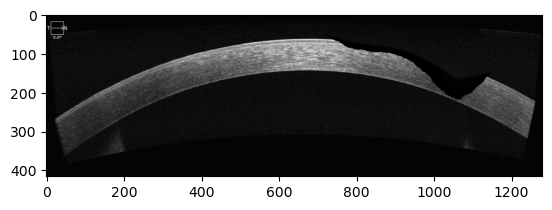

In [365]:
img = cv2.imread('../extern/images/0c8b4a2c284c3cc5ddaf.png', cv2.IMREAD_GRAYSCALE)
mask = cv2.imread('../extern/mask/1cefff8441af97dc046f.mask.png', cv2.IMREAD_GRAYSCALE)


mask = torch.tensor(mask)

interface_line = get_interface_line(mask)
interface_line[-25:] = 0 

plt.imshow(interface_line)

plt.imshow(img, cmap='gray')

plt.imshow(interface_line, alpha=0.5)


coeffs, x1, x2 = polyfit(interface_line.unsqueeze(0), 5)

H, W  = mask.shape


x = torch.arange(0, W, device=mask.device).float()
y = interpolate(coeffs, x)


length_cornea = W
noise = np.random.normal(0, 0.2, length_cornea) / 4


from scipy.signal.windows import gaussian

window = gaussian(256, std=64)

noise = np.convolve(noise, window, mode='same')

window_pos = np.random.randint(200, 1200, 1)[0]
window_length = np.random.randint(0, 600, 1)[0]
noise[:window_pos] = 0
noise[window_pos+window_length:] = 0

noise[noise>0] = 0
noise = -noise

noise_interface = y * (noise+1)
hh, ww = np.meshgrid(np.arange(0, H), np.arange(0, W), indexing='ij') 

cornea = (hh > np.expand_dims(y, 0))
interface = (hh < np.expand_dims(noise_interface, 0))

#hole = np.logical_and(hole, interface)
only_hole  = np.logical_and(interface, cornea).astype(np.uint8)
upper = ( img  * (1-cornea) ).astype(np.uint8)
result = cv2.inpaint(upper, only_hole, 5, cv2.INPAINT_TELEA)


upper = (1-cornea) + only_hole
result = result * upper + (img * (1-upper))
plt.imshow(result, cmap='gray')
plt.show()